In [3]:
import scanpy as sc 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.patches as mpatches

from scipy.stats import mannwhitneyu
import itertools

In [4]:
import sys 
sys.path.append('../../src')

from spaceoracle.oracles import BaseTravLR
from spaceoracle.plotting.cartography import Cartography


In [5]:
adata_control = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')
adata_ko = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO4_visiumHD.h5ad')
adata_ko2 = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO2_visiumHD.h5ad')

# # received ligands using normalized count
# adata_control = sc.read_h5ad('mouse_lymph1_visiumHD.h5ad')
# adata_ko = sc.read_h5ad('mouse_lymphKO4_visiumHD.h5ad')
# adata_ko2 = sc.read_h5ad('mouse_lymphKO2_visiumHD.h5ad')

In [6]:
transferred = np.loadtxt('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/degs_lymph1_transferred.txt', dtype=str)
ko_transferred = np.loadtxt('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/degs_lymphKO4_transferred.txt', dtype=str)
ko2_transferred = np.loadtxt('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/degs_lymphKO2_transferred.txt', dtype=str)

# Remove the Tregs from the transferred list since the correct proportion is low

# transferred = [cell for cell in transferred if adata_control.obs.loc[cell, 'cell_type'] != 'Treg']
# ko_transferred = [cell for cell in ko_transferred if adata_ko.obs.loc[cell, 'cell_type'] != 'Treg']
# ko2_transferred = [cell for cell in ko2_transferred if adata_ko2.obs.loc[cell, 'cell_type'] != 'Treg']


len(transferred), len(ko_transferred), len(ko2_transferred)

(488, 632, 517)

In [7]:
adata_control.X = adata_control.layers['normalized_count']
adata_ko.X = adata_ko.layers['normalized_count']
adata_ko2.X = adata_ko2.layers['normalized_count']

adata_control.obs['tissue'] = 'lymph1'
adata_ko.obs['tissue'] = 'lymphKO4'
adata_ko2.obs['tissue'] = 'lymphKO2'

In [8]:
lymph1_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymph1_visiumHD_banksy_annotated_zones.csv', index_col=0)
lymphko2_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymphKO2_visiumHD_banksy_annotated_zones.csv', index_col=0)
lymphko4_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymphKO4_visiumHD_banksy_annotated_zones.csv', index_col=0)

lymph1_banksy_df.index = lymph1_banksy_df.index.astype(str)
lymphko2_banksy_df.index = lymphko2_banksy_df.index.astype(str)
lymphko4_banksy_df.index = lymphko4_banksy_df.index.astype(str)


In [9]:
adata_control.obs['banksy_cluster'] = lymph1_banksy_df['banksy_cluster']
adata_ko.obs['banksy_cluster'] = lymphko4_banksy_df['banksy_cluster']
adata_ko2.obs['banksy_cluster'] = lymphko2_banksy_df['banksy_cluster']

adata_control.obs['1DER_cell_type'] = np.where(adata_control.obs.index.isin(transferred), adata_control.obs['cell_type'], 'NA')
adata_ko.obs['1DER_cell_type'] = np.where(adata_ko.obs.index.isin(ko_transferred), adata_ko.obs['cell_type'], 'NA')
adata_ko2.obs['1DER_cell_type'] = np.where(adata_ko2.obs.index.isin(ko2_transferred), adata_ko2.obs['cell_type'], 'NA')

adata_control.obs['1DER_cell_type'] = '1DER ' + adata_control.obs['1DER_cell_type'].astype(str)
adata_ko.obs['1DER_cell_type'] = '1DER ' + adata_ko.obs['1DER_cell_type'].astype(str)
adata_ko2.obs['1DER_cell_type'] = '1DER ' + adata_ko2.obs['1DER_cell_type'].astype(str)


### Examining gradients

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Ccl21a'}, xlabel='Ccl21a', ylabel='Density'>,
        <Axes: title={'center': 'Ccl5'}, xlabel='Ccl5', ylabel='Density'>,
        <Axes: title={'center': 'Ccl17'}, xlabel='Ccl17', ylabel='Density'>,
        <Axes: title={'center': 'Ccl22'}, xlabel='Ccl22', ylabel='Density'>],
       dtype=object))

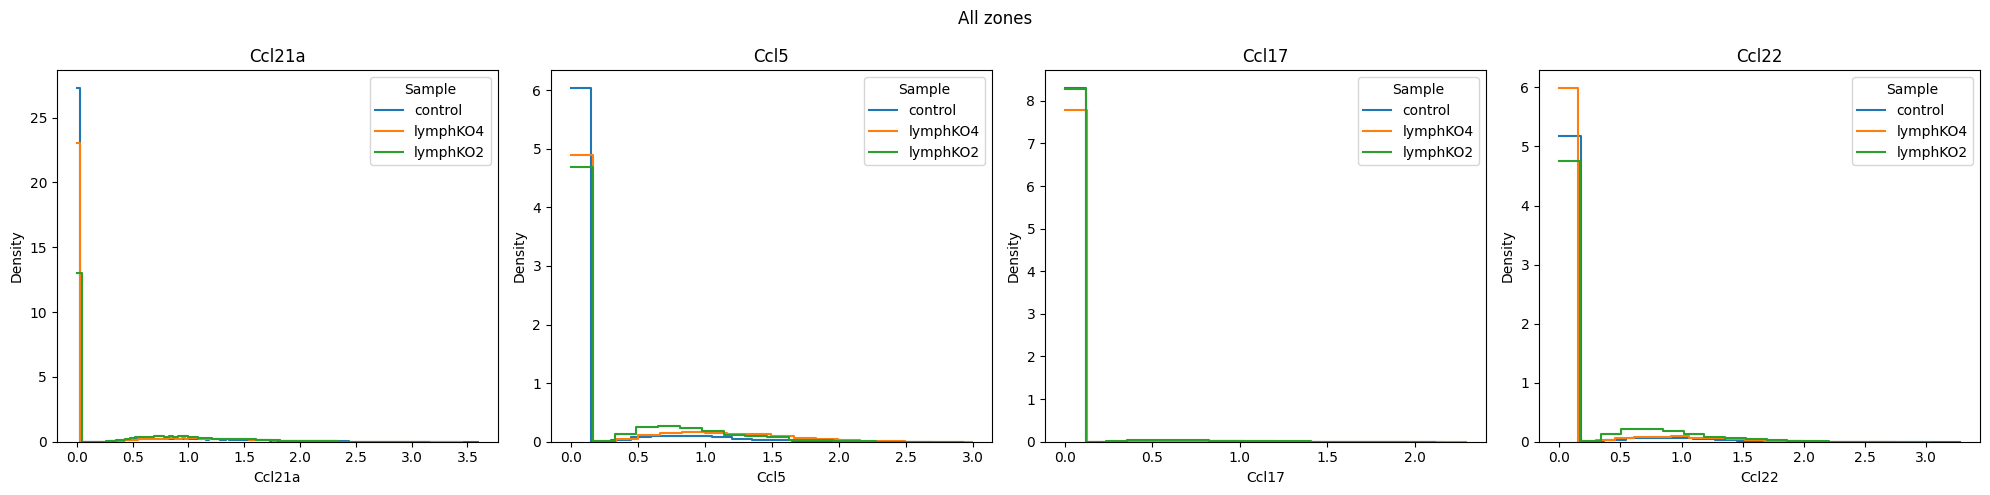

In [8]:
def plot_ligand_kde(adata_control, adata_ko, adata_ko2, ligands, zone=None):
    n_ligands = len(ligands)
    fig, axs = plt.subplots(1, n_ligands, figsize=(5 * n_ligands, 5), sharey=False, sharex=False)
    if n_ligands == 1:
        axs = [axs]
    sample_names = ['control', 'lymphKO4', 'lymphKO2']
    adatas = [adata_control, adata_ko, adata_ko2]
    colors = ['tab:blue', 'tab:orange', 'tab:green']

    for idx, ligand in enumerate(ligands):
        for adata, sample_name, color in zip(adatas, sample_names, colors):

            cell_data = adata.to_df(layer='normalized_count')
            if zone is not None:
                cell_data = cell_data[adata.obs['banksy_cluster'] == zone]

            if ligand in adata.uns['received_ligands_tfl'].columns:
                sns.histplot(
                    cell_data[ligand],
                    ax=axs[idx],
                    label=sample_name,
                    fill=False,
                    stat='density',
                    element='step', 
                    color=color
                )
        axs[idx].set_title(ligand)
        axs[idx].legend(title="Sample")
        axs[idx].set_xlabel(ligand)
        axs[idx].set_ylabel("Density")

    plt.suptitle(f'{zone if zone else "All zones"}')
    plt.tight_layout()
    return fig, axs

plot_ligand_kde(adata_control, adata_ko, adata_ko2, ['Ccl21a', 'Ccl5', 'Ccl17', 'Ccl22'])
# plot_ligand_kde(adata_control, adata_ko, adata_ko2, ['Ccl21a', 'Ccl5', 'Ccl17', 'Ccl22'], zone='B cell follicles')
# plot_ligand_kde(adata_control, adata_ko, adata_ko2, ['Ccl21a', 'Ccl5', 'Ccl17', 'Ccl22'], zone='T cell zone')
# plot_ligand_kde(adata_control, adata_ko, adata_ko2, ['Ccl21a', 'Ccl5', 'Ccl17', 'Ccl22'], zone='TB Border')



In [9]:
ligands = adata_control.uns['received_ligands_tfl'].columns.tolist()
len(ligands)

127

In [10]:
display(adata_control.to_df(layer='normalized_count')[['Ccr4', 'Ccr7']].corr())
display(adata_ko.to_df(layer='normalized_count')[['Ccr4', 'Ccr7']].corr())
display(adata_ko2.to_df(layer='normalized_count')[['Ccr4', 'Ccr7']].corr())

,Ccr4,Ccr7
Ccr4,1.00000,0.01035
Ccr7,0.01035,1.00000


,Ccr4,Ccr7
Ccr4,1.000000,0.001286
Ccr7,0.001286,1.000000


,Ccr4,Ccr7
Ccr4,1.000000,0.008646
Ccr7,0.008646,1.000000


In [11]:
zone = 'B cell follicles'

display(adata_control[adata_control.obs['banksy_cluster'] == zone].to_df(layer='normalized_count')[['Ccr4', 'Ccr7']].corr())
display(adata_ko[adata_ko.obs['banksy_cluster'] == zone].to_df(layer='normalized_count')[['Ccr4', 'Ccr7']].corr())
display(adata_ko2[adata_ko2.obs['banksy_cluster'] == zone].to_df(layer='normalized_count')[['Ccr4', 'Ccr7']].corr())


,Ccr4,Ccr7
Ccr4,1.000000,0.017062
Ccr7,0.017062,1.000000


,Ccr4,Ccr7
Ccr4,1.000000,0.006423
Ccr7,0.006423,1.000000


,Ccr4,Ccr7
Ccr4,1.000000,0.008552
Ccr7,0.008552,1.000000


In [12]:
control_th2 = adata_control[(adata_control.obs['cell_type'] == 'Th2') & (adata_control.obs.index.isin(transferred))]
ko_th2 = adata_ko[(adata_ko.obs['cell_type'] == 'Th2') & (adata_ko.obs.index.isin(ko_transferred))]
ko2_th2 = adata_ko2[(adata_ko2.obs['cell_type'] == 'Th2') & (adata_ko2.obs.index.isin(ko2_transferred))]

In [13]:
display(control_th2.to_df(layer='normalized_count')[['Ccr4', 'Ccr7']].corr())
display(ko_th2.to_df(layer='normalized_count')[['Ccr4', 'Ccr7']].corr())
display(ko2_th2.to_df(layer='normalized_count')[['Ccr4', 'Ccr7']].corr())


,Ccr4,Ccr7
Ccr4,1.000000,0.030885
Ccr7,0.030885,1.000000


,Ccr4,Ccr7
Ccr4,1.000000,-0.071994
Ccr7,-0.071994,1.000000


,Ccr4,Ccr7
Ccr4,1.00000,-0.00606
Ccr7,-0.00606,1.00000


In [14]:
zone = 'T cell zone'

display(control_th2[control_th2.obs['banksy_cluster'] == zone].to_df(layer='normalized_count')[['Ccr4', 'Ccr7']].corr())
display(ko_th2[ko_th2.obs['banksy_cluster'] == zone].to_df(layer='normalized_count')[['Ccr4', 'Ccr7']].corr())
display(ko2_th2[ko2_th2.obs['banksy_cluster'] == zone].to_df(layer='normalized_count')[['Ccr4', 'Ccr7']].corr())


,Ccr4,Ccr7
Ccr4,1.000000,0.095861
Ccr7,0.095861,1.000000


,Ccr4,Ccr7
Ccr4,1.000000,-0.081387
Ccr7,-0.081387,1.000000


,Ccr4,Ccr7
Ccr4,1.000000,0.007922
Ccr7,0.007922,1.000000


In [15]:
control_th2.to_df()

,Adam11,Adam12,Adam23,Adam8,Adamts10,Adap1,Adcy6,Adgre4,Adgre5,Adgrg6,...,Zkscan6,Zmat3,Zmat5,Zmym1,Zmynd11,Zmynd12,Zmynd15,Znfx1,Znhit2,Zup1
object_id,,,,,,,,,,,,,,,,,,,,,
198055,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.622017,0.0,0.000000,0.0,0.0,0.000000
172832,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.840928,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
211245,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.825777,0.0,0.000000,0.0,0.0,0.000000
219388,0.0,0.475547,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.475547,0.0,0.000000,0.0,0.0,0.000000
210372,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.647764,0.0,0.0,0.647764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170464,0.0,0.000000,0.381962,0.0,0.0,0.000000,0.0,0.0,0.657682,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
195762,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
247282,0.0,0.000000,0.000000,0.0,0.0,0.491156,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.819079


### Clustering on betas

In [10]:
# sc.tl.rank_genes_groups(adata_control, groupby='cell_type', groups=['Th2'], reference='rest', method='wilcoxon')
# degs_th2 = sc.get.rank_genes_groups_df(adata_control, group='Th2').sort_values('scores', ascending=False).head(10)
# display(degs_th2)

sc.tl.rank_genes_groups(adata_control, groupby="cell_type", use_raw=False)
markers_df = pd.DataFrame(adata_control.uns["rank_genes_groups"]["names"]).iloc[0:10, :]
markers = markers_df['CD8+ T'].tolist()
len(markers)

10

In [11]:
# target_genes = ["Gata3", "Il4", 'Il2ra']
# [x for x in target_genes if x in adata_control.var_names]

target_genes = markers

In [12]:
import os 

betadir = '/ix/djishnu/shared/djishnu_kor11/lasso_runs/'

data = {}
for gene in target_genes:
    dfs = []
    for sample in ['a', 'b', 'c', 'd']:
        fpath = os.path.join(betadir, f'mouse_lymph1{sample}_visiumHD', f'{gene}_betadata.parquet')
        if os.path.exists(fpath):
            dfs.append(pd.read_parquet(fpath))
    if dfs:
        data[gene] = pd.concat(dfs, axis=0)
len(data.keys())

8

In [14]:
adata = adata_control
cells_interest = adata[adata.obs['cell_type'] == 'CD8+ T'].obs.index
cells_interest = cells_interest.astype(int)

In [16]:
dfr

,beta_Angptl2#Nr4a2,beta_Angptl2$Itgb1,beta_Angptl2$Pirb,beta_Anxa1$Fpr2,beta_App$Cd74,beta_C3$Cr2,beta_C3$Itgam,beta_C3$Itgax,beta_C3$Itgb2,beta_Ccl12#Egr3,...,beta_Tnfsf11$Tnfrsf11a,beta_Tnfsf13$Tnfrsf13b,beta_Tnfsf13b#Smad1,beta_Tnfsf13b$Tnfrsf13b,beta_Tnfsf13b$Tnfrsf13c,beta_Tnfsf8$Tnfrsf8,beta_Tnfsf9#Eomes,beta_Tnfsf9$Tnfrsf9,beta_Vegfb$Flt1,beta_Xcl1$Xcr1
object_id,,,,,,,,,,,,,,,,,,,,,
200373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
271519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
adata.to_df().loc[cells_interest.astype(str), :]

,Adam11,Adam12,Adam23,Adam8,Adamts10,Adap1,Adcy6,Adgre4,Adgre5,Adgrg6,...,Zkscan6,Zmat3,Zmat5,Zmym1,Zmynd11,Zmynd12,Zmynd15,Znfx1,Znhit2,Zup1
object_id,,,,,,,,,,,,,,,,,,,,,
200373,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
169261,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.68574,0.0
198270,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.786014,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
204980,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.713408,0.0,0.0,0.0,0.00000,0.0
284697,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203952,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
282611,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
271519,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0


In [20]:
dfr = pd.concat([data[g].reindex(cells_interest, axis=0) for g in data.keys()], axis=1).fillna(0)
dfr = dfr.groupby(axis=1, level=0).mean()
dfr = dfr[[x for x in dfr.columns if ('$' in x or '#' in x)]]

dfr_ligands = [x.split('$')[0] if '$' in x else x.split('#')[0] for x in dfr.columns]
dfr_ligands = [x.replace('beta_', '') for x in dfr_ligands]
dfr_genes = [x.split('$')[1] if '$' in x else x.split('#')[1] for x in dfr.columns]

# ligands_expr = adata.uns['received_ligands'].loc[dfr.index, dfr_ligands]
ligands_expr = adata.uns['received_ligands'].loc[dfr.index.astype(str), dfr_ligands] * np.where(
    adata.uns['cell_thresholds'].loc[dfr.index.astype(str), dfr_ligands] > 0, 1, 0)
receptors_expr = adata.to_df(layer='normalized_count').loc[dfr.index.astype(str), dfr_genes]

dfr = pd.DataFrame(dfr.values * ligands_expr.values * receptors_expr.values, index=dfr.index, columns=dfr.columns)

In [ ]:
top = pd.read_csv()

In [23]:
dfr.columns[]

Index(['beta_Angptl2#Nr4a2', 'beta_Angptl2$Itgb1', 'beta_Angptl2$Pirb',
       'beta_Anxa1$Fpr2', 'beta_App$Cd74', 'beta_C3$Cr2', 'beta_C3$Itgam',
       'beta_C3$Itgax', 'beta_C3$Itgb2', 'beta_Ccl12#Egr3',
       ...
       'beta_Tnfsf11$Tnfrsf11a', 'beta_Tnfsf13$Tnfrsf13b',
       'beta_Tnfsf13b#Smad1', 'beta_Tnfsf13b$Tnfrsf13b',
       'beta_Tnfsf13b$Tnfrsf13c', 'beta_Tnfsf8$Tnfrsf8', 'beta_Tnfsf9#Eomes',
       'beta_Tnfsf9$Tnfrsf9', 'beta_Vegfb$Flt1', 'beta_Xcl1$Xcr1'],
      dtype='object', length=327)

In [21]:
if not dfr.index.is_unique:
    dfr = dfr.reset_index(drop=True)

adata_dfr = sc.AnnData(X=dfr.values, obs=pd.DataFrame(index=dfr.index), var=pd.DataFrame(index=dfr.columns))

# sc.pp.scale(adata_dfr)
sc.pp.pca(adata_dfr, n_comps=min(20, adata_dfr.shape[1]))
sc.pp.neighbors(adata_dfr, n_neighbors=10, n_pcs=min(20, adata_dfr.shape[1]))
sc.tl.umap(adata_dfr)

/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


ReferenceError: underlying object has vanished

In [16]:
adata_dfr.obs = pd.concat([adata_dfr.obs, adata.obs.loc[adata_dfr.obs.index]], axis=1)
adata_dfr

AnnData object with n_obs × n_vars = 433 × 718
    obs: 'sample', 'cell_type', 'secondary_annot', 'cell_type_int', 'x_umap', 'y_umap', 'banksy_cluster', 'tissue', '1DER_cell_type'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [17]:
sc.tl.leiden(adata_dfr, key_added="leiden", resolution=0.06)
adata_dfr.obs['leiden'] = adata_dfr.obs['leiden'].astype('category')

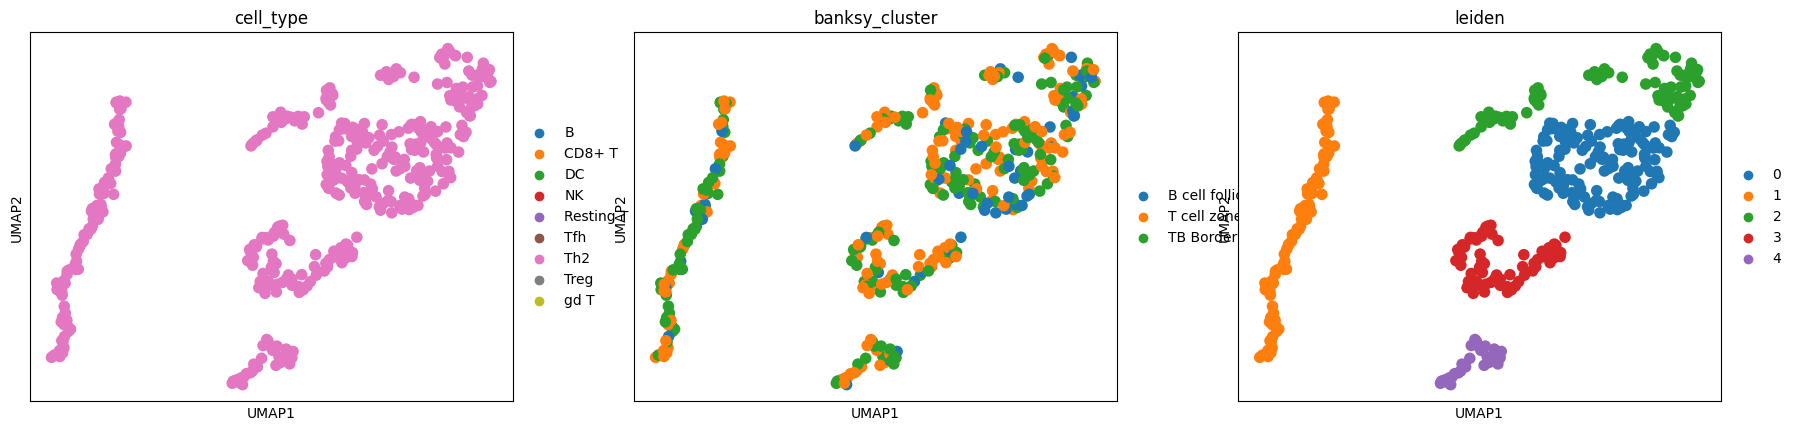

In [18]:
sc.pl.umap(adata_dfr, color=['cell_type', 'banksy_cluster', 'leiden'])

In [19]:
adata_th2 = adata[adata.obs['cell_type'] == 'CD8+ T']
adata_th2.obs['ST_leiden'] = adata_dfr.obs.loc[adata_th2.obs.index, 'leiden']

# sc.pp.scale(adata_th2)
sc.pp.pca(adata_th2, n_comps=min(20, adata_th2.shape[1]))
sc.pp.neighbors(adata_th2, n_neighbors=10, n_pcs=min(20, adata_th2.shape[1]))
sc.tl.umap(adata_th2)

/tmp/ipykernel_38308/3455390590.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_th2.obs['ST_leiden'] = adata_dfr.obs.loc[adata_th2.obs.index, 'leiden']


In [20]:
sc.tl.leiden(adata_th2, key_added="leiden", resolution=0.6)
adata_th2.obs['leiden'] = adata_th2.obs['leiden'].astype('category')


In [21]:
adata_th2.obs['leiden'].value_counts()

leiden
0    172
1    158
2     70
3     33
Name: count, dtype: int64

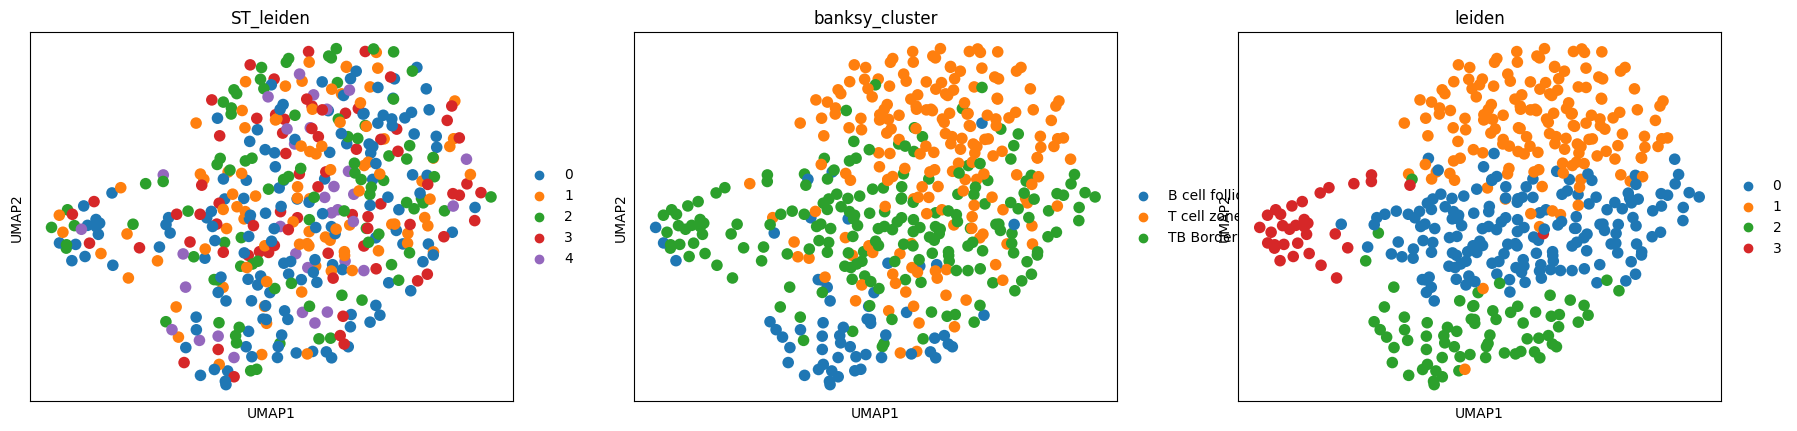

In [22]:
sc.pl.umap(adata_th2, color=['ST_leiden', 'banksy_cluster', 'leiden'])

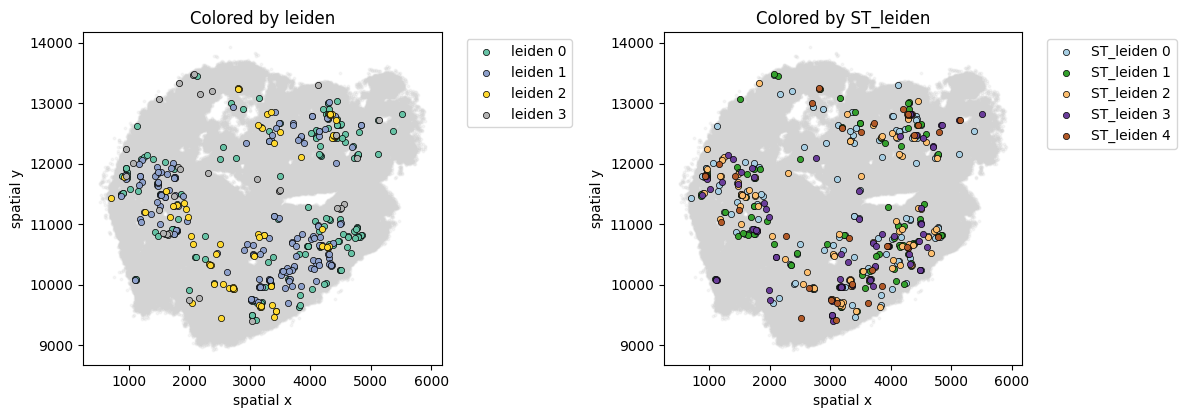

In [23]:
import matplotlib.cm as cm
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: colored by 'leiden'
ax = axes[0]
ax.set_title("Colored by leiden")
# Plot all control cells in gray for context
ax.scatter(
    adata.obsm['spatial'][:, 0],
    adata.obsm['spatial'][:, 1],
    s=3, alpha=0.2, color='lightgray'
)
leiden_labels = adata_th2.obs['leiden'].cat.categories
colors = cm.Set2(np.linspace(0, 1, len(leiden_labels)))
for color, ct in zip(colors, leiden_labels):
    idx = adata_th2.obs['leiden'] == ct
    spatial_idx = adata_th2.obs.index[idx]
    spatial_coords = adata.obsm['spatial'][[list(adata.obs.index).index(i) for i in spatial_idx]]
    ax.scatter(
        spatial_coords[:, 0],
        spatial_coords[:, 1],
        s=20, color=color, 
        label=f'leiden {ct}', edgecolor='k', linewidth=0.5
    )
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylabel("spatial y")
ax.set_xlabel("spatial x")
ax.set_aspect('equal')

# Plot 2: colored by 'ST_leiden'
ax = axes[1]
ax.set_title("Colored by ST_leiden")
# Plot all control cells in gray for context
ax.scatter(
    adata.obsm['spatial'][:, 0],
    adata.obsm['spatial'][:, 1],
    s=3, alpha=0.2, color='lightgray'
)
st_leiden_labels = adata_th2.obs['ST_leiden'].cat.categories if hasattr(adata_th2.obs['ST_leiden'], 'cat') else np.unique(adata_th2.obs['ST_leiden'])
colors = cm.Paired(np.linspace(0, 1, len(st_leiden_labels)))
for color, ct in zip(colors, st_leiden_labels):
    idx = adata_th2.obs['ST_leiden'] == ct
    spatial_idx = adata_th2.obs.index[idx]
    spatial_coords = adata.obsm['spatial'][[list(adata.obs.index).index(i) for i in spatial_idx]]
    ax.scatter(
        spatial_coords[:, 0],
        spatial_coords[:, 1],
        s=20, color=color, 
        label=f'ST_leiden {ct}', edgecolor='k', linewidth=0.5
    )
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel("spatial x")
ax.set_ylabel("spatial y")
ax.set_aspect('equal')

plt.tight_layout()


In [24]:
adata_th2.obs[['leiden', '1DER_cell_type']].value_counts()

leiden  1DER_cell_type
0       1DER NA           115
1       1DER NA            90
        1DER Th2           68
0       1DER Th2           57
2       1DER NA            46
3       1DER NA            29
2       1DER Th2           24
3       1DER Th2            4
Name: count, dtype: int64

In [25]:
adata_th2.obs[['ST_leiden', '1DER_cell_type']].value_counts()

ST_leiden  1DER_cell_type
0          1DER NA           102
2          1DER NA            56
1          1DER NA            55
3          1DER NA            45
0          1DER Th2           43
1          1DER Th2           38
2          1DER Th2           34
3          1DER Th2           27
4          1DER NA            22
           1DER Th2           11
Name: count, dtype: int64

In [26]:
adata_th2.obs[['leiden', 'ST_leiden']].value_counts()

leiden  ST_leiden
0       0            52
1       0            47
0       1            42
1       2            38
        1            36
0       3            33
2       0            33
0       2            31
1       3            28
0       4            14
2       2            14
3       0            13
2       1             9
1       4             9
2       4             8
3       2             7
2       3             6
3       1             6
        3             5
        4             2
Name: count, dtype: int64

In [27]:
# leiden cluster that is 1DER?
# B cell subset localization?

In [28]:
dfr = pd.concat([interactions['Th2'][g] for g in target_genes], axis=1).fillna(0)
dfr = dfr[[x for x in dfr.columns if ('$' in x or '#' in x)]]

dfr_ligands = [x.split('$')[0] if '$' in x else x.split('#')[0] for x in dfr.columns]
dfr_ligands = [x.replace('beta_', '') for x in dfr_ligands]
dfr_genes = [x.split('$')[1] if '$' in x else x.split('#')[1] for x in dfr.columns]

# ligands_expr = adata.uns['received_ligands'].loc[dfr.index, dfr_ligands]
ligands_expr = np.where(
    adata.uns['cell_thresholds'].loc[dfr.index, dfr_ligands] > 0,
    adata.uns['received_ligands'].loc[dfr.index, dfr_ligands],
    0
)
receptors_expr = adata.to_df(layer='normalized_count').loc[dfr.index, dfr_genes]

dfr = pd.DataFrame(dfr.values * ligands_expr * receptors_expr.values, index=dfr.index, columns=dfr.columns)
dfr.head(3)

,beta_Tgfb1$Tgfbr1,beta_Tgfb1$Tgfbr1,beta_Tgfb1$Tgfbr1,beta_Tgfb1$Tgfbr2,beta_Tgfb1$Tgfbr2,beta_Tgfb1$Tgfbr2,beta_Tgfb3$Tgfbr2,beta_Tgfb3$Tgfbr2,beta_Gdf11$Tgfbr1,beta_Gdf11$Tgfbr1,...,beta_Ebi3#Rara,beta_Tnf#Runx2,beta_Il2#Runx3,beta_Il4#Runx3,beta_Ebi3#Zbtb7a,beta_Ccl8$Ccr2,beta_Lamc1$Itga1,beta_Itgb2$Icam1,beta_Ccl12#Hivep2,beta_Ebi3#Klf3
object_id,,,,,,,,,,,,,,,,,,,,,
205621,0.000000,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.0,-0.000000e+00,-0.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198055,-0.000001,-3.293715e-09,-2.817022e-07,-8.894529e-07,-7.960032e-08,8.603012e-11,-0.0,7.098716e-11,-4.131668e-08,0.0,...,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
172832,-0.000000,-0.000000e+00,-0.000000e+00,-1.671233e-06,-1.489594e-07,1.616286e-10,-0.0,1.152105e-10,-0.000000e+00,0.0,...,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
leiden_interactions = {}
for c in adata_th2.obs['leiden'].unique():
    cells = adata_th2.obs_names[adata_th2.obs['leiden'] == c]
    leiden_interactions[c] = dfr.loc[cells].groupby(axis=1, level=0).sum().mean().sort_values(ascending=False).head(20)

st_leiden_interactions = {}
for c in adata_th2.obs['ST_leiden'].unique():
    cells = adata_th2.obs_names[adata_th2.obs['ST_leiden'] == c]
    st_leiden_interactions[c] = dfr.loc[cells].groupby(axis=1, level=0).sum().mean().sort_values(ascending=False).head(20)

In [30]:
pd.DataFrame(st_leiden_interactions) * 100000

,0,3,1,2,4
beta_Angptl2$Itgb1,0.002496,0.004678,0.003593,0.007806,0.003048
beta_App$Cd74,0.001127,NaN,NaN,NaN,0.002415
beta_C3$Itgb2,NaN,0.024285,31.180190,NaN,6.944193
beta_Ccl17$Ccr4,0.001172,0.001707,0.002299,0.003576,NaN
beta_Ccl21a$Ccr7,0.440736,0.307791,1.393190,NaN,NaN
beta_Ccl22$Ccr4,0.082910,0.130856,0.133689,0.269671,0.045007
beta_Ccl5$Ccr4,0.112295,0.148313,0.121965,0.226815,0.068957
beta_Ccl5$Ccr5,0.001337,0.068060,0.009925,0.006057,NaN
beta_Cd40lg$Cd40,0.002479,0.005721,0.003743,0.002867,0.002082
beta_Cd40lg$Itgb1,0.007986,0.012847,0.011480,0.019612,0.004946


In [31]:
dfr.groupby(axis=1, level=0).sum().sum().sort_values(ascending=False).head(20)

beta_C3$Itgb2         0.031307
beta_Il16$Cd4         0.004248
beta_Ccl21a$Ccr7      0.002156
beta_Ccl5$Ccr4        0.000610
beta_Ccl22$Ccr4       0.000596
beta_Lgals9$Ptprc     0.000266
beta_Cd40lg$Itgb2     0.000093
beta_Ccl5$Ccr5        0.000066
beta_Il15$Il2rg       0.000055
beta_Il15$Il2rb       0.000051
beta_Cd40lg$Itgb1     0.000051
beta_Il21$Il2rg       0.000019
beta_Angptl2$Itgb1    0.000018
beta_Cd40lg$Cd40      0.000014
beta_Tnf$Tnfrsf1b     0.000011
beta_Il4$Il2rg        0.000010
beta_Cxcl16$Cxcr6     0.000009
beta_Ccl17$Ccr4       0.000008
beta_Mif$Cxcr4        0.000007
beta_Mdk$Itgb1        0.000005
dtype: float64

### pathways

In [31]:
import gseapy as gp
def run_gp(degs, adata, gene_set='WikiPathways_2024_Mouse'):
    enr_degs = gp.enrichr(
        gene_list=degs,
        gene_sets=gene_set,
        organism='Mouse',
        background=adata.var_names.tolist(),
        outdir=None
    )
    enrichment_df = enr_degs.results
    return enrichment_df
# Example usage:
# run_enrichment_and_plot(down_degs, up_degs, adata_control)

In [32]:
# Groupby 'leiden'
sc.tl.rank_genes_groups(adata_th2, groupby='leiden', method='wilcoxon')
# Get top 5 DEGs for each leiden cluster
degs_leiden = []
for group in adata_th2.obs['leiden'].cat.categories:
    df = sc.get.rank_genes_groups_df(adata_th2, group=group)
    degs_leiden.append(df.head(10))
for i, group in enumerate(adata_th2.obs['ST_leiden'].cat.categories):
    print(f"\nleiden {group}")
    print(degs_leiden[i]['names'].tolist())
    display(run_gp(degs_leiden[i]['names'].tolist(), adata_th2))



leiden 0
['Cd74', 'H2-Aa', 'H2-Eb1', 'H2-Ab1', 'Ighd', 'Cd79b', 'Hist1h1e', 'H2-K1', 'Sell', 'Syk']


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2024_Mouse,Macrophage Markers WP2271,0.018783,0.069871,0,0,77.888889,309.592626,CD74
1,WikiPathways_2024_Mouse,Microglia Pathogen Phagocytosis Pathway WP3626,0.046363,0.069871,0,0,25.888889,79.511414,SYK
2,WikiPathways_2024_Mouse,Fibrin Complement Receptor 3 Signaling Pathway...,0.055400,0.069871,0,0,21.161616,61.224322,SYK
3,WikiPathways_2024_Mouse,Cytokines And Inflammatory Response WP222,0.055400,0.069871,0,0,21.161616,61.224322,H2-EB1
4,WikiPathways_2024_Mouse,IL 5 Signaling Pathway WP151,0.055400,0.069871,0,0,21.161616,61.224322,SYK
5,WikiPathways_2024_Mouse,IL 2 Signaling Pathway WP450,0.059889,0.069871,0,0,19.388889,54.584679,SYK
6,WikiPathways_2024_Mouse,IL 3 Signaling Pathway WP373,0.090782,0.090782,0,0,12.204678,29.282579,SYK



leiden 1
['Ccl22', 'Trac', 'Il2rb', 'Lck', 'Thy1', 'Cacnb3', 'Ctla4', 'Itk', 'Lat', 'Trbc2']


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2024_Mouse,IL 2 Signaling Pathway WP450,0.001526,0.019207,0,0,47.613636,308.792846,LCK;IL2RB
1,WikiPathways_2024_Mouse,Inflammatory Response Pathway WP458,0.002955,0.019207,0,0,32.656250,190.199471,LCK;IL2RB
2,WikiPathways_2024_Mouse,Microglia Pathogen Phagocytosis Pathway WP3626,0.046363,0.131130,0,0,25.888889,79.511414,LAT
3,WikiPathways_2024_Mouse,Dravet Syndrome Scn1a A1783V Point Mutation Mo...,0.046363,0.131130,0,0,25.888889,79.511414,CACNB3
4,WikiPathways_2024_Mouse,IL 5 Signaling Pathway WP151,0.055400,0.131130,0,0,21.161616,61.224322,IL2RB
5,WikiPathways_2024_Mouse,Oxidative Stress And Redox Pathway WP4466,0.068811,0.131130,0,0,16.603175,44.436620,CTLA4
6,WikiPathways_2024_Mouse,ID Signaling Pathway WP512,0.073243,0.131130,0,0,15.488889,40.487526,LCK
7,WikiPathways_2024_Mouse,Delta Notch Signaling Pathway WP265,0.086426,0.131130,0,0,12.888889,31.558062,LCK
8,WikiPathways_2024_Mouse,IL 3 Signaling Pathway WP373,0.090782,0.131130,0,0,12.204678,29.282579,LCK
9,WikiPathways_2024_Mouse,Calcium Regulation In Cardiac Cells WP553,0.103740,0.134862,0,0,10.525253,23.848826,CACNB3



leiden 2
['Igkc', 'Ighm', 'Ighg2b', 'Jchain', 'Mzb1', 'Xbp1', 'Rrm2', 'Cd24a', 'Iglc1', 'Iglc3']


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2024_Mouse,P53 Signaling WP2902,0.073243,0.10374,0,0,15.488889,40.487526,RRM2
1,WikiPathways_2024_Mouse,Purine Metabolism WP2185,0.077656,0.10374,0,0,14.513889,37.089729,RRM2
2,WikiPathways_2024_Mouse,Insulin Signaling WP65,0.103740,0.10374,0,0,10.525253,23.848826,XBP1



leiden 3
['Igfbp7', 'App', 'Clu', 'Vim', 'Mcam', 'Cdh5', 'Hspg2', 'Kdr', 'H2-Ob', 'Fabp4']


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2024_Mouse,Robo4 And VEGF Signaling Pathways Crosstalk WP...,0.004726,0.056710,0,0,inf,inf,KDR
1,WikiPathways_2024_Mouse,PPAR Signaling Pathway WP2316,0.037248,0.109865,0,0,33.317460,109.619555,FABP4
2,WikiPathways_2024_Mouse,Factors And Pathways Affecting IGF1 Akt Signal...,0.041815,0.109865,0,0,29.138889,92.501228,IGFBP7
3,WikiPathways_2024_Mouse,Dravet Syndrome Scn1a A1783V Point Mutation Mo...,0.046363,0.109865,0,0,25.888889,79.511414,KDR
4,WikiPathways_2024_Mouse,Alpha 6 Beta 4 Integrin Signaling Pathway WP488,0.050891,0.109865,0,0,23.288889,69.355899,VIM
5,WikiPathways_2024_Mouse,Alzheimer 39 S Disease WP2075,0.059889,0.109865,0,0,19.388889,54.584679,APP
6,WikiPathways_2024_Mouse,ID Signaling Pathway WP512,0.073243,0.109865,0,0,15.488889,40.487526,KDR
7,WikiPathways_2024_Mouse,Primary Focal Segmental Glomerulosclerosis FSG...,0.073243,0.109865,0,0,15.488889,40.487526,VIM
8,WikiPathways_2024_Mouse,Delta Notch Signaling Pathway WP265,0.086426,0.115234,0,0,12.888889,31.558062,APP
9,WikiPathways_2024_Mouse,Spinal Cord Injury WP2432,0.112286,0.134743,0,0,9.638889,21.077422,VIM


In [33]:
# Groupby 'ST_leiden'
sc.tl.rank_genes_groups(adata_th2, groupby='ST_leiden', method='wilcoxon')
# Get top 5 DEGs for each ST_leiden cluster
degs_st_leiden = []
for group in adata_th2.obs['ST_leiden'].cat.categories:
    df = sc.get.rank_genes_groups_df(adata_th2, group=group)
    degs_st_leiden.append(df.head(10))
for i, group in enumerate(adata_th2.obs['ST_leiden'].cat.categories):
    print(f"\nST_leiden {group}")
    print(degs_st_leiden[i]['names'].tolist())
    display(run_gp(degs_st_leiden[i]['names'].tolist(), adata_th2))



ST_leiden 0
['Ighm', 'Cap1', 'Sh3bp1', 'Itm2c', 'Cd48', 'Il7r', 'Mzb1', 'Fabp5', 'Ppp3cc', 'Rab27a']


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2024_Mouse,PPAR Signaling Pathway WP2316,0.037248,0.128175,0,0,33.317460,109.619555,FABP5
1,WikiPathways_2024_Mouse,IL 7 Signaling Pathway WP297,0.041815,0.128175,0,0,29.138889,92.501228,IL7R
2,WikiPathways_2024_Mouse,Alzheimer 39 S Disease WP2075,0.059889,0.128175,0,0,19.388889,54.584679,PPP3CC
3,WikiPathways_2024_Mouse,G Protein Signaling Pathways WP232,0.073243,0.128175,0,0,15.488889,40.487526,PPP3CC
4,WikiPathways_2024_Mouse,Insulin Signaling WP65,0.103740,0.145236,0,0,10.525253,23.848826,CAP1
5,WikiPathways_2024_Mouse,Mapk Signaling Pathway WP493,0.166070,0.193748,0,0,6.213213,11.154866,PPP3CC
6,WikiPathways_2024_Mouse,Focal Adhesion PI3K Akt mTOR Signaling Pathway...,0.243104,0.243104,0,0,3.994152,5.648794,IL7R



ST_leiden 1
['Lck', 'Kbtbd11', 'H2-K1', 'Crip1', 'Fam169b', 'Sec23b', 'Lta4h', 'Sh2d1a', 'Mki67', 'Sema4d']


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2024_Mouse,Eicosanoid Metabolism Via Lipoxygenases LOX WP...,0.018783,0.090782,0,0,77.888889,309.592626,LTA4H
1,WikiPathways_2024_Mouse,Eicosanoid Synthesis WP318,0.023429,0.090782,0,0,58.388889,219.179126,LTA4H
2,WikiPathways_2024_Mouse,Oxylipins Pathways WP5140,0.028055,0.090782,0,0,46.688889,166.846750,LTA4H
3,WikiPathways_2024_Mouse,IL 2 Signaling Pathway WP450,0.059889,0.090782,0,0,19.388889,54.584679,LCK
4,WikiPathways_2024_Mouse,Comprehensive IL 17A Signaling WP5242,0.068811,0.090782,0,0,16.603175,44.436620,MKI67
5,WikiPathways_2024_Mouse,ID Signaling Pathway WP512,0.073243,0.090782,0,0,15.488889,40.487526,LCK
6,WikiPathways_2024_Mouse,Primary Focal Segmental Glomerulosclerosis FSG...,0.073243,0.090782,0,0,15.488889,40.487526,MKI67
7,WikiPathways_2024_Mouse,Inflammatory Response Pathway WP458,0.082050,0.090782,0,0,13.653595,34.139753,LCK
8,WikiPathways_2024_Mouse,Delta Notch Signaling Pathway WP265,0.086426,0.090782,0,0,12.888889,31.558062,LCK
9,WikiPathways_2024_Mouse,IL 3 Signaling Pathway WP373,0.090782,0.090782,0,0,12.204678,29.282579,LCK



ST_leiden 2
['Tnrc6c', 'Itgb1', 'Il2rb', 'Rrm2', 'Tgfb1', 'Glrx', 'Syk', 'H2-Ob', 'Bach2', 'Prkch']


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2024_Mouse,IL 5 Signaling Pathway WP151,0.001294,0.025172,0,0,52.400000,348.455538,SYK;IL2RB
1,WikiPathways_2024_Mouse,IL 2 Signaling Pathway WP450,0.001526,0.025172,0,0,47.613636,308.792846,SYK;IL2RB
2,WikiPathways_2024_Mouse,Primary Focal Segmental Glomerulosclerosis FSG...,0.002329,0.025622,0,0,37.357143,226.465829,ITGB1;TGFB1
3,WikiPathways_2024_Mouse,Mapk Signaling Pathway WP493,0.012908,0.073777,0,0,14.375000,62.530206,TGFB1;PRKCH
4,WikiPathways_2024_Mouse,Burn Wound Healing WP5056,0.014117,0.073777,0,0,116.888889,497.987957,TGFB1
5,WikiPathways_2024_Mouse,Dopaminergic Neurogenesis WP1498,0.014117,0.073777,0,0,116.888889,497.987957,TGFB1
6,WikiPathways_2024_Mouse,Mechanisms Associated With Pluripotency WP1763,0.015650,0.073777,0,0,12.912500,53.681198,ITGB1;TGFB1
7,WikiPathways_2024_Mouse,Focal Adhesion PI3K Akt mTOR Signaling Pathway...,0.028854,0.115096,0,0,9.151786,32.447844,ITGB1;IL2RB
8,WikiPathways_2024_Mouse,Factors And Pathways Affecting IGF1 Akt Signal...,0.041815,0.115096,0,0,29.138889,92.501228,ITGB1
9,WikiPathways_2024_Mouse,Endochondral Ossification WP1270,0.041815,0.115096,0,0,29.138889,92.501228,TGFB1



ST_leiden 3
['H2-Q7', 'Stmn1', 'Atp8a1', 'Cd74', 'Ms4a4b', 'Syk', 'Vmp1', 'Iglc3', 'Bri3', 'Xrcc4']


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2024_Mouse,Non Homologous End Joining WP1242,0.009432,0.075132,0,0,233.888889,1090.785488,XRCC4
1,WikiPathways_2024_Mouse,Macrophage Markers WP2271,0.018783,0.075132,0,0,77.888889,309.592626,CD74
2,WikiPathways_2024_Mouse,Microglia Pathogen Phagocytosis Pathway WP3626,0.046363,0.079853,0,0,25.888889,79.511414,SYK
3,WikiPathways_2024_Mouse,Fibrin Complement Receptor 3 Signaling Pathway...,0.055400,0.079853,0,0,21.161616,61.224322,SYK
4,WikiPathways_2024_Mouse,IL 5 Signaling Pathway WP151,0.055400,0.079853,0,0,21.161616,61.224322,SYK
5,WikiPathways_2024_Mouse,IL 2 Signaling Pathway WP450,0.059889,0.079853,0,0,19.388889,54.584679,SYK
6,WikiPathways_2024_Mouse,IL 3 Signaling Pathway WP373,0.090782,0.103751,0,0,12.204678,29.282579,SYK
7,WikiPathways_2024_Mouse,Mapk Signaling Pathway WP493,0.166070,0.166070,0,0,6.213213,11.154866,STMN1


In [128]:
df = run_gp(degs_st_leiden[i]['names'].tolist(), adata_th2)
df

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2024_Mouse,Non Homologous End Joining WP1242,0.009432,0.075132,0,0,233.888889,1090.785488,XRCC4
1,WikiPathways_2024_Mouse,Macrophage Markers WP2271,0.018783,0.075132,0,0,77.888889,309.592626,CD74
2,WikiPathways_2024_Mouse,Microglia Pathogen Phagocytosis Pathway WP3626,0.046363,0.079853,0,0,25.888889,79.511414,SYK
3,WikiPathways_2024_Mouse,Fibrin Complement Receptor 3 Signaling Pathway...,0.055400,0.079853,0,0,21.161616,61.224322,SYK
4,WikiPathways_2024_Mouse,IL 5 Signaling Pathway WP151,0.055400,0.079853,0,0,21.161616,61.224322,SYK
5,WikiPathways_2024_Mouse,IL 2 Signaling Pathway WP450,0.059889,0.079853,0,0,19.388889,54.584679,SYK
6,WikiPathways_2024_Mouse,IL 3 Signaling Pathway WP373,0.090782,0.103751,0,0,12.204678,29.282579,SYK
7,WikiPathways_2024_Mouse,Mapk Signaling Pathway WP493,0.166070,0.166070,0,0,6.213213,11.154866,STMN1


In [131]:
il3_pathway = pd.read_csv('WP373-datanodes.tsv', sep='\t')
il3_pathway

,Label,Type,Identifier,Comment,Ensembl,NCBI gene,HGNC,UniProt,Wikidata,ChEBI,InChI,PubChem,ChemSpider,HMDB,KEGG,LipidMaps
0,IL3,GeneProduct,ncbigene:16187,NaN,ensembl:ENSMUSG00000018914,ncbigene:16187,NaN,uniprot:P01586;uniprot:Q5SX77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Stat1,GeneProduct,ncbigene:20846,NaN,ensembl:ENSMUSG00000026104,ncbigene:20846,NaN,uniprot:Q8CFQ1;uniprot:Q8C3V4;uniprot:A0A087WR...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Raf1,GeneProduct,ncbigene:110157,NaN,ensembl:ENSMUSG00000000441,ncbigene:110157,NaN,uniprot:A0A0N4SWH5;uniprot:F6TUC4;uniprot:Q99N...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Stat5a,GeneProduct,ncbigene:20850,NaN,ensembl:ENSMUSG00000004043,ncbigene:20850,NaN,uniprot:B2C3G8;uniprot:Q9JIA0;uniprot:A2A5D4;u...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fcer2a,GeneProduct,ncbigene:14128,NaN,ensembl:ENSMUSG00000005540,ncbigene:14128,NaN,uniprot:A0A140LJ27;uniprot:Q8VH33;uniprot:A0A1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Socs3,GeneProduct,ncbigene:12702,NaN,ensembl:ENSMUSG00000053113,ncbigene:12702,NaN,uniprot:O35718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,Rac1,GeneProduct,ncbigene:19353,NaN,ensembl:ENSMUSG00000001847,ncbigene:19353,NaN,uniprot:Q3TLP8;uniprot:P63001;uniprot:K7Q7T7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,Bcl2l1,GeneProduct,ncbigene:12048,NaN,ensembl:ENSMUSG00000007659,ncbigene:12048,NaN,uniprot:Q64373;uniprot:Q9QWX2;uniprot:A2AHX9;u...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,CDC42,GeneProduct,ncbigene:12540,NaN,ensembl:ENSMUSG00000006699,ncbigene:12540,NaN,uniprot:P60766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### b cell localization subset

In [28]:
adata = adata_control

In [29]:
adata.obs.cell_type.value_counts()

cell_type
B            67597
CD8+ T        9148
Resting T     6991
DC            1807
Treg          1607
Tfh           1060
Th2            433
gd T           362
NK             291
Name: count, dtype: int64

In [30]:
from scipy.spatial import cKDTree

b_idx = adata.obs_names[adata.obs['cell_type'] != 'Th2']
t_idx = adata.obs_names[adata.obs['cell_type'] == 'Th2']

b_coords = adata[adata.obs['cell_type'] != 'Th2'].obsm['spatial']
t_coords = adata[adata.obs['cell_type'] == 'Th2'].obsm['spatial']

b_tree = cKDTree(b_coords)

b_near_t = {}
for i, (t_name, t_coord) in enumerate(zip(t_idx, t_coords)):
    idxs = b_tree.query_ball_point(t_coord, r=40)
    b_near_t[t_name] = list(b_idx[idxs])


In [31]:
gex_df = adata.to_df(layer='normalized_count')

b_neighbors = {}
for cell, gex in b_near_t.items():
    b_neighbors[cell] = gex_df.loc[b_near_t[cell]].mean()

b_neighbors = pd.DataFrame(b_neighbors).T

In [32]:
b_neighbors = sc.AnnData(
    X = b_neighbors.values,
    obs = adata.obs.loc[b_neighbors.index],
    var = pd.DataFrame(index=b_neighbors.columns)
)

b_neighbors.X = np.nan_to_num(b_neighbors.X, nan=0)
b_neighbors

AnnData object with n_obs × n_vars = 433 × 2116
    obs: 'sample', 'cell_type', 'secondary_annot', 'cell_type_int', 'x_umap', 'y_umap', 'banksy_cluster', 'tissue', '1DER_cell_type'

In [33]:
b_neighbors.obs['y'] = b_neighbors.obs['1DER_cell_type'].map({'1DER Th2': 1, '1DER NA': 0})

In [34]:
import scanpy as sc

sc.tl.rank_genes_groups(
    b_neighbors,
    groupby='1DER_cell_type',
    method='wilcoxon',
    use_raw=False
)

degs = sc.get.rank_genes_groups_df(b_neighbors, group='1DER Th2')
degs

,names,scores,logfoldchanges,pvals,pvals_adj
0,Trbc1,5.378228,0.472327,7.522271e-08,0.000159
1,Itk,4.545123,0.389100,5.490332e-06,0.005303
2,Trac,4.478442,0.323057,7.518982e-06,0.005303
3,Ms4a6b,4.245863,0.349845,2.177533e-05,0.011519
4,Trbc2,4.123348,0.313149,3.734050e-05,0.013221
...,...,...,...,...,...
2111,H2-Ab1,-3.252886,-0.292408,1.142394e-03,0.083355
2112,Cd74,-3.317156,-0.304737,9.093879e-04,0.076971
2113,H2-Eb1,-3.497917,-0.271131,4.689077e-04,0.062013
2114,Bank1,-3.900410,-0.446134,9.602992e-05,0.020320


In [35]:
degs.to_csv('degs_all_neighbors_control.csv')

In [36]:
degs_ko2 = pd.read_csv('degs_all_neighbors_ko2.csv', index_col=0)
degs_ko4 = pd.read_csv('degs_all_neighbors_ko4.csv', index_col=0)
degs_control = pd.read_csv('degs_all_neighbors_control.csv', index_col=0)

degs = pd.merge(degs_ko2, degs_ko4, on='names', how='outer', suffixes=('_2', '_4'))
degs = pd.merge(degs, degs_control, on='names', how='outer', suffixes=('ko', '_control'))

degs

,names,scores_2,logfoldchanges_2,pvals_2,pvals_adj_2,scores_4,logfoldchanges_4,pvals_4,pvals_adj_4,scores,logfoldchanges,pvals,pvals_adj
0,Adam11,0.197731,-0.030052,0.843256,1.000000,0.103465,-0.017097,0.917594,1.0,-0.283593,-0.355484,0.776722,0.999956
1,Adam12,-0.448524,-0.114779,0.653775,1.000000,0.898419,0.453147,0.368962,1.0,-0.738708,-0.234793,0.460084,0.999956
2,Adam23,-0.782914,-0.310652,0.433678,1.000000,0.298323,-0.016355,0.765456,1.0,-0.780885,-0.225466,0.434870,0.994814
3,Adam8,0.271317,0.151875,0.786147,1.000000,-1.652562,-0.473217,0.098420,1.0,0.968475,0.144641,0.332807,0.941348
4,Adamts10,0.980144,0.094012,0.327015,1.000000,0.261536,0.033220,0.793679,1.0,1.465767,0.169870,0.142712,0.741169
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2111,Zmynd12,-0.228266,-2.147996,0.819439,1.000000,0.105189,16.889475,0.916226,1.0,0.032135,0.239733,0.974364,1.000000
2112,Zmynd15,1.776073,0.222437,0.075721,0.944916,0.164969,0.160701,0.868969,1.0,1.169721,0.246182,0.242113,0.849168
2113,Znfx1,0.320875,-0.006842,0.748305,1.000000,0.517898,0.088517,0.604529,1.0,0.369555,0.119622,0.711714,0.999956
2114,Znhit2,-1.679461,-0.475255,0.093062,0.944916,1.055915,0.189977,0.291007,1.0,-1.395471,-0.200202,0.162874,0.775626


In [37]:
degs['scores_ko'] = degs['scores_2'] + degs['scores_4']
degs['logfoldchanges_ko'] = degs['logfoldchanges_2'] + degs['logfoldchanges_4']

degs.sort_values(by='scores_ko', ascending=False, inplace=True)

In [38]:
degs = degs[
    ((degs['logfoldchanges_2'] > 0) & (degs['logfoldchanges_4'] > 0)) 
    | ((degs['logfoldchanges_2'] < 0) & (degs['logfoldchanges_4'] < 0))
]

In [39]:
degs

,names,scores_2,logfoldchanges_2,pvals_2,pvals_adj_2,scores_4,logfoldchanges_4,pvals_4,pvals_adj_4,scores,logfoldchanges,pvals,pvals_adj,scores_ko,logfoldchanges_ko
857,Il16,3.633241,0.223220,0.000280,0.526208,3.435029,0.392830,0.000592,0.439689,-0.255475,-0.014505,7.983564e-01,0.999956,7.068270,0.616050
1904,Trbc1,2.563493,0.199328,0.010362,0.692454,3.530447,0.348513,0.000415,0.439689,5.378228,0.472327,7.522271e-08,0.000159,6.093939,0.547841
277,Cd52,3.012517,0.137233,0.002591,0.526208,2.385437,0.177390,0.017059,1.000000,1.145620,0.043577,2.519525e-01,0.852961,5.397953,0.314623
2050,Zbtb7b,3.031038,0.401438,0.002437,0.526208,1.978476,0.413314,0.047875,1.000000,0.899786,0.137964,3.682343e-01,0.963144,5.009514,0.814753
1763,Tbc1d22b,2.181046,0.302333,0.029180,0.868864,2.508445,0.466671,0.012126,1.000000,1.842150,0.283913,6.545316e-02,0.586484,4.689491,0.769004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,Timm44,-2.272653,-0.254945,0.023047,0.837605,-1.442183,-0.320968,0.149251,1.000000,0.488857,0.118254,6.249431e-01,0.999956,-3.714836,-0.575914
169,Bmpr2,-1.779077,-0.393125,0.075227,0.944916,-1.955483,-0.678112,0.050526,1.000000,-0.274354,-0.101278,7.838124e-01,0.999956,-3.734560,-1.071236
259,Cd24a,-1.653430,-0.312778,0.098243,0.944916,-2.426248,-0.448804,0.015256,1.000000,-2.311726,-0.348169,2.079279e-02,0.382587,-4.079678,-0.761582
71,App,-2.916405,-0.321849,0.003541,0.624381,-1.547373,-0.134024,0.121773,1.000000,-2.179168,-0.291217,2.931917e-02,0.436897,-4.463777,-0.455873


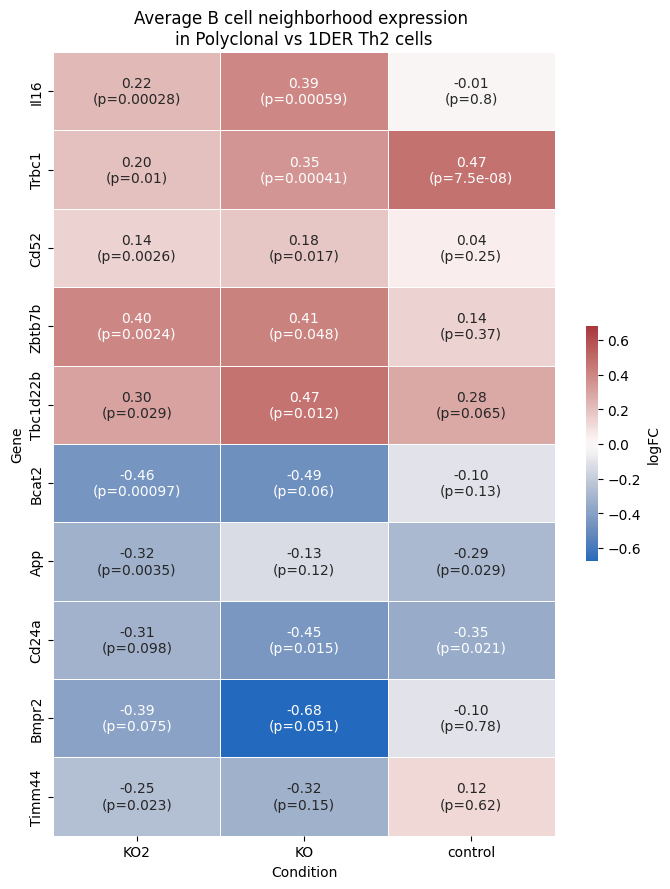

In [40]:
# Select top and bottom 5 genes as before
# Select top and bottom 10 genes by summed KO logFC, requiring consistent direction in both KO2 and KO4
top_5 = degs[(degs['logfoldchanges_ko'] > 0)].sort_values(by='scores_ko', ascending=False).head(5)
bottom_5 = degs[(degs['logfoldchanges_ko'] < 0)].sort_values(by='scores_ko', ascending=True).head(5)
selected_degs = pd.concat([top_5, bottom_5])

relabel = {
    'logfoldchanges_2': 'KO2',
    'logfoldchanges_4': 'KO',
    'logfoldchanges': 'control'
}

# Prepare heatmap data for logfoldchanges
heatmap_data = selected_degs.set_index('names')[['logfoldchanges_2', 'logfoldchanges_4', 'logfoldchanges']]
heatmap_data.columns = [relabel.get(col, col) for col in heatmap_data.columns]

# Prepare annotation data with logfoldchange and p-value
def make_annot(row):
    # For each condition, show logFC and pval
    return [
        f"{row['logfoldchanges_2']:.2f}\n(p={row['pvals_2']:.2g})",
        f"{row['logfoldchanges_4']:.2f}\n(p={row['pvals_4']:.2g})",
        f"{row['logfoldchanges']:.2f}\n(p={row['pvals']:.2g})"
    ]

annot_data = selected_degs.apply(make_annot, axis=1, result_type='expand')
annot_data.index = selected_degs['names']
annot_data.columns = heatmap_data.columns

max_abs = np.abs(heatmap_data.values).max()
vmax = max_abs

plt.figure(figsize=(7, 0.7 * heatmap_data.shape[0] + 2))
sns.heatmap(
    heatmap_data,
    annot=annot_data.values,
    fmt='',
    cmap='vlag',
    center=0,
    linewidths=0.5,
    vmin=-vmax,
    vmax=vmax,
    cbar_kws={'label': 'logFC', 'shrink': 0.3}
)
plt.xlabel('Condition')
plt.ylabel('Gene')
plt.title('Average B cell neighborhood expression \nin Polyclonal vs 1DER Th2 cells')
plt.tight_layout()
plt.show()


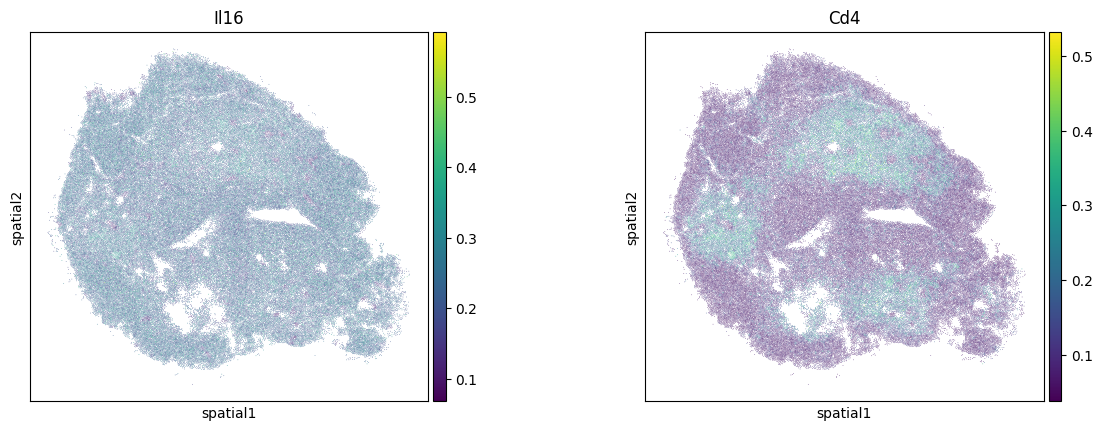

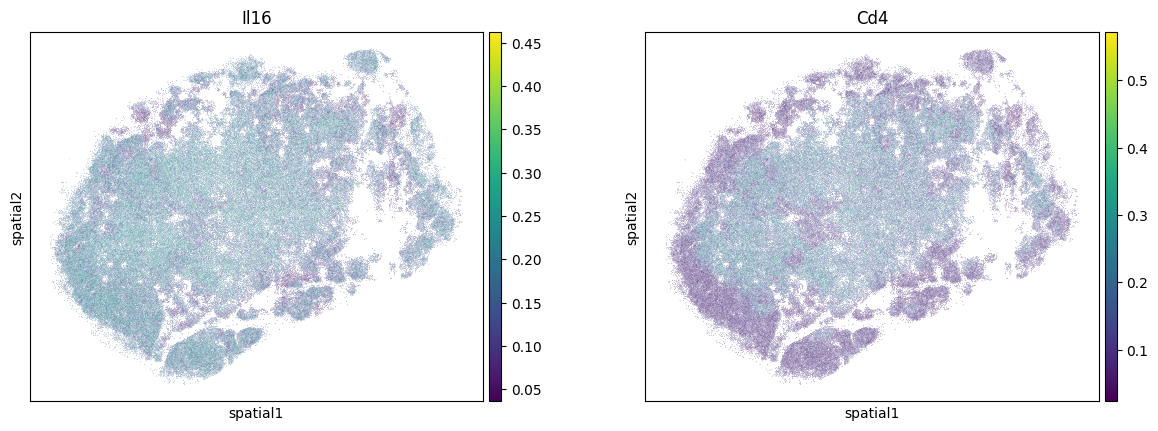

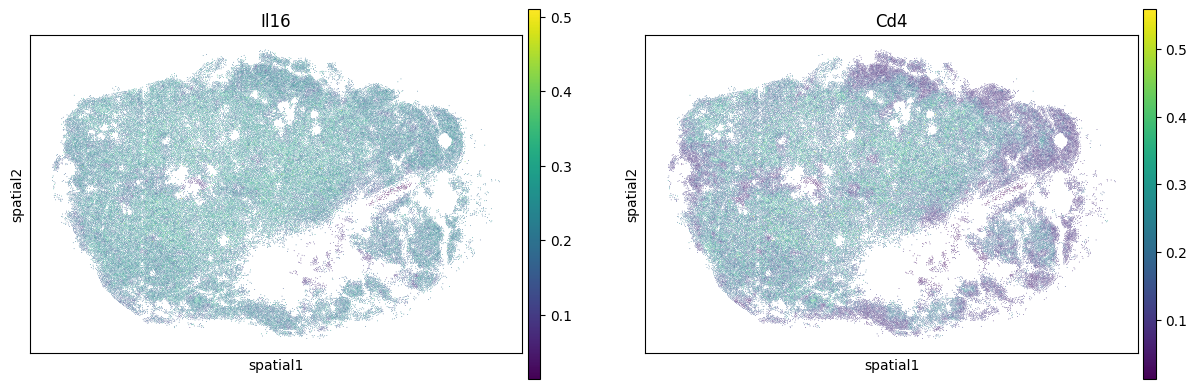

In [4]:
sc.pl.spatial(adata_control, color=['Il16', 'Cd4'], spot_size=10, layer='imputed_count')
sc.pl.spatial(adata_ko, color=['Il16', 'Cd4'], spot_size=10, layer='imputed_count')
sc.pl.spatial(adata_ko2, color=['Il16', 'Cd4'], spot_size=10, layer='imputed_count')